<h1><center> Low Rank Tensor Minimum Mean Square Error Filter Design</center></h1>

In [6]:
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt

#from numpy import linalg as lg
#from numpy import random as rd

np.set_printoptions(3)

Using numpy backend.


## Multiple User MIMO System

In this presentation is considered a single transmission cell with only one Base Station(BS) receiving signals from U Users Equipments(UE) in the uplink scenario. Each UE is equipped with only one omni-directional antenna and the BS employs a Uniform Linear Array(ULA) of N omni-directional antennas whose axis is parallel to the ground plane. If the carrier wavelength is $\lambda$ the spacing between the array antennas is considered to be $d = \frac{\lambda}{2}$. Our objective here is to filter a specific signal send by one of the UEs to the BS using tools from Tensor Algebra and also minimize the effects of noise and interference presented in the channel.

## Channel Model

Channel Spatial Response: 

\begin{equation}
     \mathbf{a}(\theta_{l,u}) = [1, ...,  e^{-j \pi (N - 1) \cos(\theta_{l,u})} ] \in \mathbb{C}^{Nx1}
\end{equation}

Pulse-Shaping Waveform:

\begin{equation}
    \mathbf{g}(\tau_{l,u}) = [g(-\tau_{l,u}), ..., g((Q-1)T - \tau_{l,u})]^{T} \in \mathbb{C}^{QX1}
\end{equation}
        
Channel Equation:

\begin{equation}
     H_{u} = \sum^{L - 1}_{l = 0} \alpha_{l,u} a_{n}(\theta_{l,u})  g(qT - \tau_{l,u})^{T} \in \mathbb{C}^{NxQ}
\end{equation}

Where $\alpha_{l,u}$ is the complex channel gain and $\tau_{l,u}$ is the propagation delay.

In [7]:
def channel(N,Q,L,U):
    #N : Number of Antennas.
    #Q : Size of the Buffer.
    #L : Number of Multipaths per User.
    #U : Number of Users.
    
    #Wavelength of the Carrier.
    l = 1
    #Speed of light
    c = 3**8
    #Symbol Period.    
    T = 10**-5
    #N antennas and Q bits of buffer.
    h = np.zeros((N,Q))
    
    #Complex Channel Gain with zero mean and unitary variance.
    alpha = (np.random.normal(0,1,[L,U]) + 1j*np.random.normal(0,1,[L,U]))
    #alpha = (alpha - np.mean(alpha))/np.std(alpha)
    alpha = alpha/np.sqrt(2)

    #Angles of Arrival in the Antennas.
    theta = -np.pi/2 + np.pi*np.random.rand(L,U)
    
    #Matrix of Collum Steering Vectors .
    #To acess the l path from the u User Equipament use the notation svector[:,l,u].
    n = np.linspace(0,N-1,N)
    s = (1j*np.pi*n)[:,np.newaxis,np.newaxis]
    svector = (np.exp(s*np.cos(theta)))[:,np.newaxis,:,:]
    
    #Propagation Delays for Each Receiver Antenna.
    tau = l/(2*c*np.cos(theta))[:,:,np.newaxis,np.newaxis]
    
    #Pulse-shaping waveform.
    q = np.linspace(0,Q-1,Q)
    g = np.sinc(q*T - tau)
    g = np.reshape(g,(1,Q,L,U))
    
    #Create a concatenation of all channels
    h = (svector*g)
    h = alpha*h
    
    #Multi-paths Combination
    h = np.sum(h,axis = 2) 
    
    #Creating a Tensor Channel that is given by H = [H1 H2 ... Hu]
    h = tl.tensor(h)
    h = tl.unfold(h,0)
    #h = h/np.linalg.norm(h)
    
    return h

In [4]:
L,U = 4,2
theta = -np.pi/2 + np.pi*np.random.rand(L,U)

print("Angles of Arrival path x user:")
print(np.degrees(theta))

Angles of Arrival path x user:
[[-36.092 -66.026]
 [-83.513 -73.17 ]
 [-68.823  -6.058]
 [ 41.032  23.216]]


In [5]:
N,Q,L,U = 8,2,6,2
h = channel(N,Q,L,U)
print(h.shape)

(8, 4)


## Transmited Signal 

\begin{equation}
x_{n}[k] = \sum^{U}_{u = 1} \sum^{Q - 1}_{q = 0} \sum^{L - 1}_{l = 0} \alpha_{l,u} g(qT - \tau_{l,u}) a_{n}(\theta_{l,u}) s_{u}[k-q] + b_{n}[k] \in \mathcal{C}^{N \times 1}
\end{equation}

Matrix Notation:

\begin{equation}
    \mathbf{x}[k] = \sum^{U}_{u = 1} \mathbf{H}_{u} \mathbf{s}_{u}[k] + \mathbf{b}[k] \in \mathbb{C}^{NX1} 
\end{equation}

The Case of Analysis:

\begin{equation}
    \mathbf{x}[k] = \mathbf{H}_{u} \mathbf{s}_{u}[k] +  \sum^{U}_{j \neq u} \mathbf{H}_{j} \mathbf{s}_{j}[k] + \mathbf{b}[k] \in \mathbb{C}^{NX1}
\end{equation}

In the equation above is possible to perceived that every UE signal is being sending at a single antenna. Furthermore, is also important to say that the SNR in this problem is described by:

\begin{equation}
    SNR = \frac{\sigma^{2}_{s}}{\sigma^{2}_{n}}
\end{equation}

In [8]:
def modulated_signal(K,U):
    #K: Size of Transmited Signal.
    #U: Number of Users.
    
    #BPSK Modulation for a group of random signals from UEs.
    sm = np.random.randint(0,1+1,size = (K,U))
    sm.real[sm.real == 0] = -1
    
    return sm

In [7]:
K,U = 64,2
sm = modulated_signal(K,U)

print("Transmited Signal from User 1:")
print(sm[:,0])
print("Mean:",np.abs(np.mean(sm[:,0])),"Variance:",np.var(sm[:,0]))
print("Transmited Signal from User 2")
print(sm[:,1])
print("Mean:",np.abs(np.mean(sm[:,1])),"Variance:",np.var(sm[:,1]))
print("Format of Transmited Signal:")
print(sm.shape)

Transmited Signal from User 1:
[ 1  1 -1  1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1
  1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1  1 -1  1
 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1]
Mean: 0.125 Variance: 0.984375
Transmited Signal from User 2
[ 1 -1 -1  1  1 -1  1  1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1 -1  1  1]
Mean: 0.125 Variance: 0.984375
Format of Transmited Signal:
(64, 2)


In [9]:
def sampled_signal(sm,Q,K,U,k):
    #sm: Modulated Signal.
    #N : Number of Antennas.
    #Q : Size of the Buffer.
    #L : Number of Multipaths per User.
    #K : Size of Transmited Signal.
    #U : Number of Users.
    #k : Instant of Sampling.
    
    S = np.zeros([U,Q])
    
    #This block simulates the change of signal throughout time in the buffer of data.
    for i in range(0,U):
        s = sm[:,i]
        s = s[:,np.newaxis]
        s = np.append(s,np.zeros([1,Q]))
        s = s[k:k+Q]
        s = (s[::-1])
        S[i,:] = s
        
    #Its necessary that K > Q for now.
    return S

In [9]:
Q,K,U = 8,64,2
sm = modulated_signal(K,U)
print(sm.T)
print(sm.shape)

[[ 1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1
   1  1  1  1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1  1 -1
   1  1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1 -1  1
   1  1  1  1 -1  1 -1  1  1 -1  1 -1  1  1  1  1]]
(64, 2)


In [10]:
k = 0
S = sampled_signal(sm,Q,K,U,k)
print(S)

[[-1. -1.  1.  1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]]


In [11]:
K,U = 16,3
sm = modulated_signal(K,U)

In [10]:
def sampled_matrix(sm,K,Q,U):
    
    SS = tl.tensor(np.zeros([K,Q,U]))
    
    for j in range(0,U):
        for i in range(0,K):
            S = sampled_signal(sm,Q,K,U,i)
            SS[i,:,j] = S[j,:]

    SS = np.transpose(SS)
    SS = tl.unfold(SS,2)
    return SS

In [13]:
Q = 4
S = sampled_matrix(sm,K,Q,U)
print(S)

[[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.]
 [-1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.]
 [-1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.]
 [-1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1.]
 [ 0.  1. -1.  1.  0. -1.  1. -1.  0. -1. -1. -1.]
 [ 0.  0.  1. -1.  0.  0. -1.  1.  0.  0. -1. -1.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0. -1.]]


In [11]:
def received_signal(S,h,N,K,SNR_dB):
    #S: Matrix of delayed signals.
    #h: Channel Matrix.
    #N: Number of Antennas.
    #K: Buffer Sizer.
    
    SNR_Linear = 10**(SNR_dB/10)
    b = (1/SNR_Linear)*(np.random.normal(0,1,[N,K]) + 1j*np.random.normal(0,1,[N,K]))
    
    X = h@np.transpose(S)
    Y = X + b
    
    return Y,X

In [15]:
N,Q,L,U,K,SNR_dB = 32,8,4,4,512,30
h = channel(N,Q,L,U)
sm = modulated_signal(K,U)
S = sampled_matrix(sm,K,Q,U)
[Y,X] = received_signal(S,h,N,K,SNR_dB)

print("Signal Transmited to Filter:")
print(Y)
print("Size of the Transmited Signal:")
print(Y.shape)

Signal Transmited to Filter:
[[  1.854 +6.748j  -1.633 +5.517j   0.478 +5.046j ...   2.644 -3.694j
    0.642 -7.086j  -2.094 -5.755j]
 [ -5.202 +0.516j   4.234 +6.755j -10.08 -10.122j ...   0.895 -2.839j
    0.645 -2.665j   5.617 +4.012j]
 [  0.46  -4.883j -11.647 +3.559j   6.55  +1.907j ...   4.409 +4.214j
    6.98  -1.927j  -1.863 -2.193j]
 ...
 [ -1.434-16.392j  -2.564+11.676j  -2.762-13.021j ...   2.109 +4.229j
    2.971 -1.403j   1.808 +8.122j]
 [  8.501 +6.856j -15.4   -1.33j   11.152 +1.227j ...   1.434 -1.254j
    6.636 -1.024j  -5.146 -2.85j ]
 [ -0.21  -0.952j  -0.921 -7.724j   0.481 -5.135j ...  -1.685 +2.065j
    0.623 +7.316j   1.155 +4.623j]]
Size of the Transmited Signal:
(32, 512)


## Equalizer Filter Problem

A equalizer filter that can extract the desired signal from the received ones and compensate for channel distortions, multi-use interference and noise is considered. Let $\mathbf{w} \in \mathbb{C}^{Nx1}$ be the filter weights vector, the equalizer output can be written as:

\begin{equation}
    y[k] = \mathbf{w}^{H} \mathbf{x}[k]
\end{equation}

The Minimum Square Error(MSE) is considered as optimization metric, therefore the equalizer design problem can be formulated as:

\begin{equation}
    \underset{\mathbf{w_{d}}}{\text{minimize}} \mathbb{E}[|s_{u}[k - \delta] - y[k]|^{2}]    
\end{equation}

## Linear MMSE

In [7]:
def linear_mmse(Y,S,K,N):
    
    Ryy = (Y@np.conj(Y).T)/K
    P   = Y@np.conj(S[:,0])/K
    
    #w_lmmse >> NXQU
    w_lmmse = (np.linalg.inv(Ryy)@P)[:,np.newaxis]
    Y_Filtered = np.zeros([N,K],dtype = 'complex')
    
    for i in range(0,N):
        w = (np.conj(w_lmmse[i,:]).T)[:,np.newaxis]
        Y_Filtered[i,:] = np.multiply(w,Y[i,:])
        
    return Y_Filtered

In [21]:
N,Q,L,U,K,SNR_dB = 6,3,4,4,512,15
h = channel(N,Q,L,U)
sm = modulated_signal(K,U)
S = sampled_matrix(sm,K,Q,U)
[Y,X] = received_signal(S,h,N,K,SNR_dB)
Y_Filtered = linear_mmse(Y,S,K,N)

Filtered Signal X Shape:
(6, 512)
Source Signal Shape:
(6, 512)


/home/kennethb/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kennethb/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


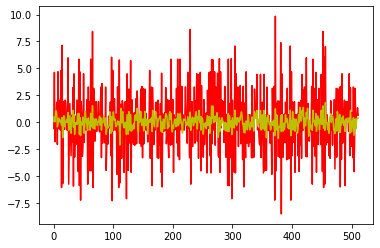

/home/kennethb/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kennethb/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


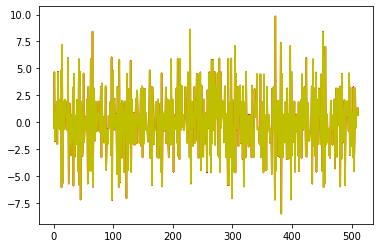

In [22]:
print('Filtered Signal X Shape:')
print(Y_Filtered.shape)
print('Source Signal Shape:')
print(X.shape)

plt.plot(X[0,:],'r')
plt.plot(Y_Filtered[0,:],'y')
plt.show()

plt.plot(X[0,:],'r')
plt.plot(Y[0,:],'y')
plt.show()

## Low Rank Tensor MMSE

Initially be the number of antennas N at the BS factorized as bellow so we can reshape the vector $\mathbf{w}$ into a D-th order tensor $\mathcal{W} \in \mathbb{C}^{N1x...xN_{D}}$. The same goes for vector $\mathbf{x}[k]$ that is reshape in a tensor $\mathcal{X}[k] \in \mathbb{C}^{N_{1}x...xN_{D}}$:
    
\begin{equation}
    N = \prod^{D}_{d = 1} N_{d}     
\end{equation}
        
Considering that the tensor filter can be factorized as a Canonical Polyadic Decomposition(CPD):
        
\begin{equation}
    y[k] = \mathbf{w}^{H} \mathbf{x}[k] = \langle \mathcal{X}[k], \mathcal{W} \rangle = \sum^{N_{1},...N_{D}}_{n_{1}, ..., n_{D} = 1} x_{n_{1}, ..., n_{D}}[k] [\mathcal{W}]^{*}_{n_{1}, ..., n_{D}} 
\end{equation}
        
\begin{equation}
    y[k] = \mathbf{w}^{H} \mathbf{x}[k] = \langle \mathcal{X}[k], \mathcal{W} \rangle = \sum^{N_{1},...N_{D}}_{n_{1}, ..., n_{D} = 1} x_{n_{1}, ..., n_{D}}[k] (\sum^{R}_{r = 1} [w_{1,r}]^{*}_{n_{1}} ... [w_{D,r}]^{*}_{n_{D}})
\end{equation}

 Is possible to rewrite the previous equation with the aid of the n-mode product:
        
\begin{equation}
    y[k] = \sum^{R}_{r = 1} \mathcal{X}[k] \times_{1} \mathbf{w}^{H}_{1,r} ... \times_{D} \mathbf{w}^{H}_{D,r} 
\end{equation}
        
Written the output in function of the d-th filter vector:
        
\begin{equation}
    y[k] = \sum^{R}_{r = 1} \mathbf{w}^{H}_{d,r} (\mathcal{X}[k] \times_{1} \mathbf{w}^{H}_{1,r} ... \times_{d - 1} \mathbf{w}^{H}_{d - 1,r} \times_{d + 1} \mathbf{w}^{H}_{d + 1,r} ... \times_{D} \mathbf{w}^{H}_{D,r}) 
\end{equation}
        
\begin{equation}
    y[k] = \sum^{R}_{r = 1} \mathbf{w}^{H}_{d,r} u_{d,r}[k] = \mathbf{w}^{H}_{d} \mathbf{u}_{d}[k]
\end{equation}

he multilinear filter output can be used to reformulate the linear equalization problem:
        
\begin{equation}
    \underset{\mathbf{w_{d}}}{\text{minimize}} \mathbb{E}[|s_{u}[k - \delta] - \mathbf{w}^{H}_{d} \mathbf{u}_{d}[k]|^{2}] , d \in \{ 1, ..., D \}   
\end{equation}
        
This problem can be viewed as a low-dimensional MMSE scenario. Therefore, we can solve the equation for each mode until a convergence criterion is satisfied. The solution for this problem can be formulated as:
        
\begin{equation}
    \mathbf{w}_{d,MMSE} = \mathbf{R}^{-1}_{u_{d},u_{d}} \mathbf{p}_{u_{d}} \in \mathbb{C}^{RN_{d}X1}
\end{equation}
        
\begin{equation}
    \mathbf{R}_{u_{d},u_{d}} = \mathbb{E} [\mathbf{u_{d}}[k] \mathbf{u}^{H}_{d}[k]] \in \mathbb{C}^{RN_{d}XRN_{d}}
\end{equation}
        
\begin{equation}
    \mathbf{p}_{u_{d}} = \mathbb{E} [\mathbf{u_{d}}[k] \mathbf{s}^{*}_{u}[k - \delta]] \in \mathbb{C}^{RN_{d}X1}
\end{equation}

 The previous statistics can be approximated as:
        
\begin{equation}
    \mathbf{R}_{u_{d},u_{d}} \approx \frac{\mathbf{U}_{d} \mathbf{U}^{H}_{d}}{K} \in \mathbb{C}^{RN_{d}XRN_{d}}
\end{equation}
        
\begin{equation}
    \mathbf{p}_{u_{d}} \approx \frac{\mathbf{U}_{d} \mathbf{s}^{*}_{u}}{K} \in \mathbb{C}^{RN_{d}X1}
\end{equation}
        
Where the matrix $\mathbf{U}_{d}$ can be defined as:
        
\begin{equation}
    \mathbf{U}_{d} = [\mathbf{U}^{T}_{d,1}, ..., \mathbf{U}^{T}_{d,R}]^{T} \in \mathbb{C}^{RN_{d}XR}
\end{equation}
        
\begin{equation}
    \mathbf{U}_{d,r} = \mathcal{X}[k] \times_{1} \mathbf{w}^{H}_{1,r} ... \times_{d - 1} \mathbf{w}^{H}_{d - 1,r} \times_{d + 1} \mathbf{w}^{H}_{d + 1,r} ... \times_{D} \mathbf{w}^{H}_{D,r} \in \mathbb{C}^{RN_{d}X1}
\end{equation}

## LR-TMMSE Filter Design

In [318]:
def LRTMMSE_filter(Y,K,N_d,signal_matrix,signal_user,user):
    #Y: Signal received of dimensions NxK
    #K: Size of the signal source.
    #N_d: Antena factorization that respects the following propertie of 
    # N = (np.prod(N_d))
    #signal_matrix: Matrix of delayed signals.
    #signal_user: Source signals before delayed and formating.
    #user: The user that has the desirable signal to filter from the massive 
    # data Y.
    #OBS: This code will be projected to work with a fixed value of order D e 
    # rank R for tensors for the sake of simplicity.
        
    # RESHAPE = dim externa .... dim externa linha coluna


    #Order of decomposition that'll be used in the antena factorization.
    D = 3
    #Ranking of the filter that'll be constructed.
    R = 3
    #Constant to be used in future approximations.
    epsilon = 1
    
    #Selecting the desireable user signal from all the source signals received.
    signal_user = signal_user[:, user] # Um user por vez
    
    #Inicializing all the linear filters in a tensor filter.
    #w = tl.tensor(np.zeros([np.prod(N_d)]).reshape(N_d))
    #OBS: This could add indesirable interference to the first frontal slice of 
    # tensor since the degrees of freedom would be reduced. 
    
    #Inicializing all the linear filters in a matrix like structure.
    w_d0 = np.zeros([N_d[0],R],dtype='complex') 
    w_d0[0,:] = np.random.rand(R)
    w_d1 = np.zeros([N_d[1],R],dtype='complex') 
    w_d1[0,:] = np.random.rand(R)
    w_d2 = np.zeros([N_d[2],R],dtype='complex') 
    w_d2[0,:] = np.random.rand(R)
    
    #Identity Tensor.
    I = np.zeros((D,)*R)
    I[tuple([np.arange(D)]*R)] = 1
    
    #Creating a tensor from the received signal.
    #Y_tensor = tl.tensor(Y.reshape(N_d[0],N_d[1],N_d[2],K))
    Y_tensor = tl.tensor(Y.reshape(K, N_d[2], N_d[0], N_d[1]))

    #OBS: Is important to note here that np.reshape() in python run through 
    # the rows and not through the columns.
    
    #Creating a serie of tensors to storage data from matrices U_dr to be 
    # used in future processing of filter coefficients.
    #U = tl.tensor(np.ones((D,R,3,3),dtype="complex"))
    u_d0 = tl.tensor(np.zeros([R, N_d[0], K],dtype = 'complex'))
    u_d1 = tl.tensor(np.zeros([R, N_d[1], K],dtype = 'complex'))
    u_d2 = tl.tensor(np.zeros([R, N_d[2], K],dtype = 'complex'))
    
    
    #Creating matrices to storage statistical data to be used in future 
    # processing of filter coefficients.
    Rxx_d0 = np.zeros([R*N_d[0],R*N_d[0]],dtype = 'complex')
    Rxx_d1 = np.zeros([R*N_d[1],R*N_d[1]],dtype = 'complex')
    Rxx_d2 = np.zeros([R*N_d[2],R*N_d[2]],dtype = 'complex')
    
    P_d0 = np.zeros([R*N_d[0],1],dtype = 'complex') 
    P_d1 = np.zeros([R*N_d[1],1],dtype = 'complex')
    P_d2 = np.zeros([R*N_d[2],1],dtype = 'complex')
    
    #This statement is necessary to prevent the algorithm to do unnecessary 
    # calculations, since the convergence criterion should be achieved in until 
    # 5 attempts.
    i = 0
    while i < 10:
        for j in range(0,D):
            for k in range(0,R):
                if j == 0: # EQ (18) 256 2 8 4 // 8 4 2
                    u_d0[k] = (tl.tenalg.multi_mode_dot(Y_tensor, [w_d1[:,k].conj().T, w_d2[:,k].conj().T], modes=[3,1])).T
                
                if j == 1:
                    u_d1[k] = (tl.tenalg.multi_mode_dot(Y_tensor, [w_d0[:,k].conj().T, w_d2[:,k].conj().T],  modes=[2,1])).T
                    
                else:
                    u_d2[k] = (tl.tenalg.multi_mode_dot(Y_tensor, [w_d0[:,k].conj().T, w_d1[:,k].conj().T],modes=[2,3])).T
                    
            #OBS: The np.hstack is a column-wise operation.      
            if j == 0:
                u0 = np.hstack(np.moveaxis(u_d0, 1, 2)).T
                Rxx_d0 = (u0@(np.conj(u0).T))/K
                P_d0 = (u0@(np.conj(signal_user)))/K
                w0 = np.linalg.inv(Rxx_d0)@P_d0
                
            if j == 1:
                u1 = np.hstack(np.moveaxis(u_d1, 1, 2)).T
                Rxx_d1 = (u1@(np.conj(u1).T))/K
                P_d1 = (u1@(np.conj(signal_user)))/K
                w1 = np.linalg.inv(Rxx_d1)@P_d1
                
            else:
                u2 = np.hstack(np.moveaxis(u_d2, 1, 2)).T   
                Rxx_d2 = (u2@(np.conj(u2).T))/K
                P_d2 = (u2@(np.conj(signal_user)))/K             
                w2 = np.linalg.inv(Rxx_d2)@P_d2
        

        if (np.linalg.norm(w0.flatten(order='F') -\
                           w_d0.flatten(order='F'))**2 < epsilon)\
             or (np.linalg.norm(w1.flatten(order='F') -\
                                w_d1.flatten(order='F'))**2 < epsilon)\
             or (np.linalg.norm(w2.flatten(order='F') -\
                                w_d2.flatten(order='F'))**2 < epsilon):
            
            W = tl.base.tensor_to_vec(tl.tenalg.multi_mode_dot(I,[w_d0, w_d1, w_d2],modes=[0,1,2]))
            w = tl.base.tensor_to_vec(W) 
            
            i = i + 1
            break
        
        w_d0 = w0.reshape(N_d[0], R, order='F')
        w_d1 = w1.reshape(N_d[1], R, order='F')
        w_d2 = w2.reshape(N_d[2], R, order='F')
        
        i = i + 1
        
    #Creating the tensor filter from the matricial coefficients.
    W = tl.base.tensor_to_vec(tl.tenalg.multi_mode_dot(I,[w_d0, w_d1, w_d2],modes=[0,1,2]))
    #Creating a vector from the tensor for the sake of simplicity in future 
    # numerical computations.
    w = tl.base.tensor_to_vec(W) 
    
    return w,i

In [340]:
N,Q,L,U,K,SNR_dB,user = 512,8,4,2,256,15,0
N_d = np.array([32,8,2])

h = channel(N,Q,L,U)
signal_user = modulated_signal(K,U)#From the user i want to filter.
signal_matrix = sampled_matrix(signal_user,K,Q,U)
[Y,X] = received_signal(signal_matrix,h,N,K,SNR_dB)
[w,i] = LRTMMSE_filter(Y,K,N_d,signal_matrix,signal_user,user)
print('Number of Realizations:')
print(i)

Number of Realizations:
1


## Signal to Interference and Noise Ratio

\begin{equation}
    SINR_{out} = \frac{w^{H} R_{dd} w}{w^{H} (R_{ii} + R_{bb}) w}
\end{equation}

Where the Correlation Matrices are:

\begin{equation}
    R_{xx} = R_{dd} + R_{ii} + R_{bb}
\end{equation}

\begin{equation}
    R_{dd} = H_{u} R_{ss} H^{H}_{u}
\end{equation}

\begin{equation}
    R_{ii} = \sum^{U}_{k \ne u} H_{j} R_{ss} H^{j}_{H}
\end{equation}

\begin{equation}
    R_{ss} = \sigma^{2}_{s} I_{Q}
\end{equation}

\begin{equation}
    R_{bb} = \sigma^{2}_{n} I_{N}
\end{equation}

In [580]:
def sinr(SNR_dB,h,w,u):
    
    R_ss = np.var(signal_user[:,u])*np.eye(Q)
    R_dd = h[:,0:Q]@R_ss@np.conj(h[:,0:Q]).T
    
    SINR = np.zeros([1,SNR_dB+1],dtype = 'complex')
    
    for i in range(1,SNR_dB+1):
        [Y,X] = received_signal(signal_matrix,h,N,K,i)
        R_yy  = np.cov(Y)
        R_bb  = (1/i)*np.eye(N)
        R_ii = R_yy - (R_bb + R_dd)
        SINR[0,i] = (np.conj(w).T@R_dd@w)/(np.conj(w).T@(R_ii+R_bb)@w)
    
    SINR = (SINR.T)[:,0]
    SINR = SINR[1:]
    
    return SINR

In [ ]:
N,N_d,Q,L,U,K,SNR_dB,user,u = 128,np.array([16,4,2]),8,4,2,512,30,0,0
SINR = 0

for i in range(0,100):
    h = channel(N,Q,L,U)
    signal_user = modulated_signal(K,U)
    signal_matrix = sampled_matrix(signal_user,K,Q,U)
    for j in range(0,100):
        [Y,X] = received_signal(signal_matrix,h,N,K,SNR_dB)
        [w,i] = LRTMMSE_filter(Y,K,N_d,signal_matrix,signal_user,user)

        SINR = SINR + sinr(SNR_dB,h,w,u)

In [ ]:
plt.figure()
plt.plot(np.arange(1,SNR_dB+1),10*np.log(np.abs(SINR)))
plt.show()

## Complexity Analysis

\begin{equation}
    P_{MMSE}(N,K) = N^{2}K + NK + O(N^{3}) + N^{2}    
\end{equation}

\begin{equation}
    P_{LRTMMSE}(\{N\},D,I,K) = I[\sum^{D}_{d = 1} R(D - 1)NK + N^{2}_{d}K + N_{d}K + O(N^{3}_{d}) + N^{2}_{d}]   
\end{equation}

In [426]:
def complexity_analysis(I,R,K):
    #I : Number of Interations.
    #R : Rank of the Filter.
    #K : Size of the Signal
    
    #Number of Antennas.
    N = 512
    
    #Complexity as Function of K:
    
    #Order of the Filter
    D = 2
    K1 = np.arange(1,K+1) 
    N1 = [64,16]
    P_LRTMMSE2 = np.zeros([K,])
    for j in range(1,K+1):
        for i in range(0,D):
            P_LRTMMSE2[j-1,] = P_LRTMMSE2[j-1,] + I*(R*(D-1)*N*j + j*N1[i]**2 + j*N1[i] + N1[i]**3 + N1[i]**2)
    
    #Order of the Filter
    D = 3
    K1 = np.arange(1,K+1) 
    N1 = [64,8,2]
    P_LRTMMSE3 = np.zeros([K,])
    for j in range(1,K+1):
        for i in range(0,D):
            P_LRTMMSE3[j-1,] = P_LRTMMSE3[j-1,] + I*(R*(D-1)*N*j + j*N1[i]**2 + j*N1[i] + N1[i]**3 + N1[i]**2)
    
    #Order of the Filter
    D = 4
    K1 = np.arange(1,K+1) 
    N1 = [32,4,4,2]
    P_LRTMMSE4 = np.zeros([K,])
    for j in range(1,K+1):
        for i in range(0,D):
            P_LRTMMSE4[j-1,] = P_LRTMMSE4[j-1,] + I*(R*(D-1)*N*j + j*N1[i]**2 + j*N1[i] + N1[i]**3 + N1[i]**2)
    
    #Order of the Filter
    D = 5
    K1 = np.arange(1,K+1) 
    N1 = [16,4,4,2,2]
    P_LRTMMSE5 = np.zeros([K,])
    for j in range(1,K+1):
        for i in range(0,D):
            P_LRTMMSE5[j-1,] = P_LRTMMSE5[j-1,] + I*(R*(D-1)*N*j + j*N1[i]**2 + j*N1[i] + N1[i]**3 + N1[i]**2)
    
    #Order of the Filter
    D = 6
    K1 = np.arange(1,K+1) 
    N1 = [8,4,4,2,2,2]
    P_LRTMMSE6 = np.zeros([K,])
    for j in range(1,K+1):
        for i in range(0,D):
            P_LRTMMSE6[j-1,] = P_LRTMMSE6[j-1,] + I*(R*(D-1)*N*j + j*N1[i]**2 + j*N1[i] + N1[i]**3 + N1[i]**2)
  
    P_MMSE = K1*N**2 + K1*N + N**3 + N**2
    
    plt.figure()
    plt.semilogy(K1,P_MMSE, label='MMSE') 
    plt.semilogy(K1,P_LRTMMSE2, label='LRTMMSE for D = 2') 
    plt.semilogy(K1,P_LRTMMSE3, label='LRTMMSE for D = 3') 
    plt.semilogy(K1,P_LRTMMSE4, label='LRTMMSE for D = 4') 
    plt.semilogy(K1,P_LRTMMSE5, label='LRTMMSE for D = 5') 
    plt.semilogy(K1,P_LRTMMSE6, label='LRTMMSE for D = 6') 
    plt.title('Complexity Analysis as a Function of K')
    plt.xlabel('Training Sequence of Length K')
    plt.ylabel('Number of Products')  
    plt.legend()
    plt.show()
    
    #Complexity as Function of N:
    D = 3
    K = 600
    P_MMSE = np.zeros([9,]) 
    N = [[2,2,2],[4,2,2],[4,4,2],[8,4,2],[16,4,2],[32,4,2],[64,4,2],[128,4,2],[256,4,2]]
    
    for k in range(0,9):
        N1 = np.prod(N[k])
        P_MMSE[k,] = P_MMSE[k,] + K*(N1**2) + K*N1 + N1**3 + N1**2
    
    R = 1
    P_LRTMMSE1 = np.zeros([9,])
    for j in range(0,9):
        N1 = N[j]
        for i in range(0,D):
            P_LRTMMSE1[j,] = P_LRTMMSE1[j,] + I*(R*(D-1)*np.sum(N1)*K + K*N1[i]**2 + K*N1[i] + N1[i]**3 + N1[i]**2)
            
    R = 2
    P_LRTMMSE2 = np.zeros([9,])
    for j in range(0,9):
        N1 = N[j]
        for i in range(0,D):
            P_LRTMMSE2[j,] = P_LRTMMSE2[j,] + I*(R*(D-1)*np.sum(N1)*K + K*N1[i]**2 + K*N1[i] + N1[i]**3 + N1[i]**2)
    
    R = 3
    P_LRTMMSE3 = np.zeros([9,])
    for j in range(0,9):
        N1 = N[j]
        for i in range(0,D):
            P_LRTMMSE3[j,] = P_LRTMMSE3[j,] + I*(R*(D-1)*np.sum(N1)*K + K*N1[i]**2 + K*N1[i] + N1[i]**3 + N1[i]**2)
            
    R = 4
    P_LRTMMSE4 = np.zeros([9,])
    for j in range(0,9):
        N1 = N[j]
        for i in range(0,D):
            P_LRTMMSE4[j,] = P_LRTMMSE4[j,] + I*(R*(D-1)*np.sum(N1)*K + K*N1[i]**2 + K*N1[i] + N1[i]**3 + N1[i]**2)

    plt.figure()
    plt.semilogy([8,16,32,64,128,256,512,1024,2048],P_MMSE, label='MMSE') 
    plt.semilogy([8,16,32,64,128,256,512,1024,2048],P_LRTMMSE1, label='LRTMMSE for R = 1') 
    plt.semilogy([8,16,32,64,128,256,512,1024,2048],P_LRTMMSE2, label='LRTMMSE for R = 2') 
    plt.semilogy([8,16,32,64,128,256,512,1024,2048],P_LRTMMSE3, label='LRTMMSE for R = 3') 
    plt.semilogy([8,16,32,64,128,256,512,1024,2048],P_LRTMMSE4, label='LRTMMSE for R = 4') 
    plt.title('Complexity Analysis as a Function of N')
    plt.xlabel('Number of Antennas N')
    plt.ylabel('Number of Products')  
    plt.legend()
    plt.show()
    
    #Traçar para em função de D.
    return

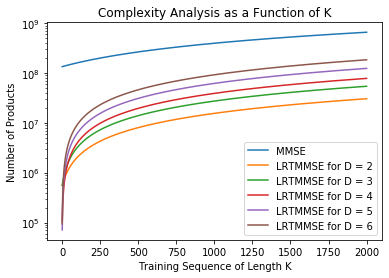

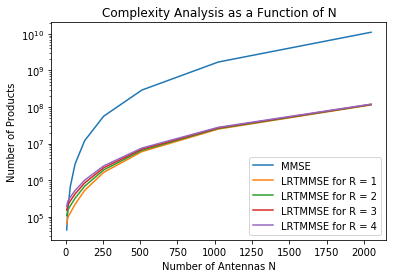

In [427]:
I,R,K = 2,3,2000
complexity_analysis(I,R,K)